# The diffusion equation - parallelized

In [42]:
import ipyparallel as ipp
rc = ipp.Client()
# shutdown all engines:
rc.shutdown(targets='all')

Waiting for connection file: ~/.ipython/profile_default/security/ipcontroller-client.json


OSError: Connection file '~/.ipython/profile_default/security/ipcontroller-client.json' not found.
You have attempted to connect to an IPython Cluster but no Controller could be found.
Please double-check your configuration and ensure that a cluster is running.

In [43]:
import ipyparallel as ipp
# Note, this is only for jupyter notebooks
# Start the cluster
cluster = ipp.Cluster(engines="mpi", n=8)
cluster.engine_launcher_class.mpi_args = ["--use-hwthread-cpus"]
client = cluster.start_and_connect_sync()
client.ids

Starting 8 engines with <class 'ipyparallel.cluster.launcher.MPIEngineSetLauncher'>
100%|██████████| 8/8 [00:12<00:00,  1.61s/engine]


[0, 1, 2, 3, 4, 5, 6, 7]

In [44]:
%%px
dx = 0.1
nt = 100000
dt = 0.001
D = 1 # diffusion constant
print("test"+str(dx))


NoEnginesRegistered: This operation requires engines. Try client.wait_for_engines(n) to wait for engines to register.

## 2D domain decomposition

In [34]:
%%px
#
import numpy as np
import matplotlib.pyplot as plt
from mpi4py import MPI
#
comm = MPI.COMM_WORLD
size = comm.Get_size()
rank = comm.Get_rank()
#
# Let us take a square simulation domain that can be divided 
# by the number of cores and results in a square subdomain 
NX = 200
NY = 400
#
# print('NX = {} NY = {}, and sqrt(NX*NY) = {}'.format(NX,NY,np.sqrt(NX*NY)))
# print('NX/NY = {} and NY/NX = {}\n'.format(NX/NY,NY/NX))
#
if NX < NY:
    sectsX=int(np.floor(np.sqrt(size*NX/NY)))
    sectsY=int(np.floor(size/sectsX))
    # print('We have {} fields in x-direction and {} in y-direction'.format(sectsX,sectsY))
    # print('How do the fractions look like?')
    # print('NX/NY={} and sectsX/sectsY = {}\n'.format(NX/NY,sectsX/sectsY))
elif NX > NY:
    sectsY=int(np.floor(np.sqrt(size*NY/NX)))
    sectsX=int(np.floor(size/sectsY))
    # print('We have {} fields in x-direction and {} in y-direction'.format(sectsX,sectsY))
    # print('How do the fractions look like?')
    # print('NX/NY={} and sectsX/sectsY = {}\n'.format(NX/NY,sectsX/sectsY))
elif NX==NY:
    sectsY=int(np.floor(np.sqrt(size)))
    sectsX=int(size/sectsY)
    if rank == 0: print('In the case of equal size we divide the processes as {} and {}'.format(sectsX,sectsY))
#
# print('Rank {}/{} is alive.'.format(rank, size))
#
sectsX=int(np.floor(np.sqrt(size)))
sectsY=int(size//sectsX)
#
#sectsX=int(sys.argv[3])
#sectsY=int(sys.argv[4])
nxsub = NX//sectsX+2
print(sectsX)
print(sectsY)
nysub = NY//sectsY+2
boundary_k=[False,False,False,False]
cartcomm=comm.Create_cart(dims=[sectsX,sectsY],periods=[True,True],reorder=False)
rcoords = cartcomm.Get_coords(rank)
print(rcoords)
#
# where to receive from and where send to 
sR,dR = cartcomm.Shift(1,1)
sL,dL = cartcomm.Shift(1,-1)
sU,dU = cartcomm.Shift(0,1)
sD,dD = cartcomm.Shift(0,-1)
sd = np.array([sR,dR,sL,dL,sU,dU,sD,dD], dtype = int)
print(sd)

[stdout:4] 2
4
[1, 0]
[7 5 5 7 0 0 0 0]


[stdout:0] 2
4
[0, 0]
[3 1 1 3 4 4 4 4]


[stdout:2] 2
4
[0, 2]
[1 3 3 1 6 6 6 6]


[stdout:6] 2
4
[1, 2]
[5 7 7 5 2 2 2 2]


[stdout:5] 2
4
[1, 1]
[4 6 6 4 1 1 1 1]


[stdout:3] 2
4
[0, 3]
[2 0 0 2 7 7 7 7]


[stdout:7] 2
4
[1, 3]
[6 4 4 6 3 3 3 3]


[stdout:1] 2
4
[0, 1]
[0 2 2 0 5 5 5 5]


In [53]:
%px %matplotlib notebook

<AsyncResult(%px): pending>

In [30]:
%%px
allrcoords = comm.gather(rcoords,root = 0)

allDestSourBuf = np.zeros(size*8, dtype = int)
comm.Gather(sd, allDestSourBuf, root = 0)
#
if rank == 0:
    print(allrcoords)
    print(allDestSourBuf)
    cartarray = np.ones((4,4))
    allDestSour = np.array(allDestSourBuf).reshape((size,8))
    for i in np.arange(size):
        cartarray[allrcoords[i][0],allrcoords[i][1]] = i
        #print(allDestSour[i,:])
        sR,dR,sL,dL,sU,dU,sD,dD = allDestSour[i]
        print('Rank {} is at {}'.format(i,allrcoords[i]))
        print('sour/dest right {} {}, sour/dest left {} {},  sour/dest up {} {},  sour/dest down {} {},'.format(sR,dR,sL,dL,sU,dU,sD,dD))
    print(cartarray)

[stdout:0] [[0, 0], [0, 1], [0, 2], [0, 3], [1, 0], [1, 1], [1, 2], [1, 3]]
[3 1 1 3 4 4 4 4 0 2 2 0 5 5 5 5 1 3 3 1 6 6 6 6 2 0 0 2 7 7 7 7 7 5 5 7 0
 0 0 0 4 6 6 4 1 1 1 1 5 7 7 5 2 2 2 2 6 4 4 6 3 3 3 3]
Rank 0 is at [0, 0]
sour/dest right 3 1, sour/dest left 1 3,  sour/dest up 4 4,  sour/dest down 4 4,
Rank 1 is at [0, 1]
sour/dest right 0 2, sour/dest left 2 0,  sour/dest up 5 5,  sour/dest down 5 5,
Rank 2 is at [0, 2]
sour/dest right 1 3, sour/dest left 3 1,  sour/dest up 6 6,  sour/dest down 6 6,
Rank 3 is at [0, 3]
sour/dest right 2 0, sour/dest left 0 2,  sour/dest up 7 7,  sour/dest down 7 7,
Rank 4 is at [1, 0]
sour/dest right 7 5, sour/dest left 5 7,  sour/dest up 0 0,  sour/dest down 0 0,
Rank 5 is at [1, 1]
sour/dest right 4 6, sour/dest left 6 4,  sour/dest up 1 1,  sour/dest down 1 1,
Rank 6 is at [1, 2]
sour/dest right 5 7, sour/dest left 7 5,  sour/dest up 2 2,  sour/dest down 2 2,
Rank 7 is at [1, 3]
sour/dest right 6 4, sour/dest left 4 6,  sour/dest up 3 3,  sour/

In [45]:
%%px
# Initial conditions
nx = 800
ny = 400
dx = 0.1
nt = 10000
dt = 0.001
D = 1 # diffusion constant
# Define the gridpoints
c = np.zeros((int(nx/size)+2, int(ny/size)+2), dtype=float)
# print(c.shape)
x = np.arange(rcoords[0]*NX//4,(rcoords[0]+1)*NX//4)*dx
y = np.arange(rcoords[1]*NY//4,(rcoords[1]+1)*NY//4)*dx
X,Y = np.meshgrid(x,y)
#
sigma0 = 30*dx
c[1:-1,1:-1] = np.exp(-((X-NX/2*dx)**2+(Y-NY/2*dx)**2)/(2*sigma0**2)) / (np.sqrt(2*np.pi)*sigma0)

NoEnginesRegistered: This operation requires engines. Try client.wait_for_engines(n) to wait for engines to register.

In [36]:
%%px
c_full_range = np.zeros((NX*NY))
print(nxsub)
print(nysub)
print(c.shape)
comm.Gather(c[1:-1,1:-1].reshape((nxsub-2)*((nysub-2)//2)), c_full_range, root = 0)
rcoords_x = comm.gather(rcoords[0], root=0)
rcoords_y = comm.gather(rcoords[1], root=0)
if rank == 0:
    xy = np.array([rcoords_x,rcoords_y]).T
    c_plot = np.zeros((NX,NY))
#
    for i in np.arange(4):
        for j in np.arange(4):
            k = i*4+j
            xlo = NX//4*xy[k,1]
            xhi = NX//4*(xy[k,1]+1)
            ylo = NY//4*xy[k,0]
            yhi = NY//4*(xy[k,0]+1)
            clo = k*NX*NY//16
            chi = (k+1)*NX*NY//16
            #print('{} to {} into {} {} to {} {}'.format(clo,chi,xlo,ylo,xhi,yhi))
            #print((xhi-xlo)*(yhi-ylo),chi-clo)
            c_plot[xlo:xhi,ylo:yhi] = c_full_range[clo:chi].reshape(NX//4,NY//4)
#
    #plt.imshow(c_plot.T)
    plt.plot(c_plot[:,NX//2])
    

[stdout:1] 102
102
(102, 52)


[stdout:2] 102
102
(102, 52)


[stdout:4] 102
102
(102, 52)


[stdout:7] 102
102
(102, 52)


[stdout:6] 102
102
(102, 52)


[stdout:5] 102
102
(102, 52)


[stdout:3] 102
102
(102, 52)


%px: 100%|██████████| 8/8 [00:00<00:00, 30.46tasks/s]


AlreadyDisplayedError: 7 errors

mpiexec error output:
--------------------------------------------------------------------------
Primary job  terminated normally, but 1 process returned
a non-zero exit code. Per user-direction, the job has been aborted.
--------------------------------------------------------------------------
2022-07-13 17:48:39.027 [IPEngine.1] CRITICAL | received signal 15, stopping
--------------------------------------------------------------------------
mpiexec noticed that process rank 0 with PID 0 on node LAPTOP-RB7RSNJP exited on signal 11 (Segmentation fault).
--------------------------------------------------------------------------

engine set stopped 1657725771: {'exit_code': 139, 'pid': 584, 'identifier': 'ipengine-1657725770-i1ux-1657725771-324'}


In [37]:
%%px
# Communication between subdomains
def Communicate(c,cartcomm,sd):
    recvbuf = np.zeros(c[:,1].shape[0])
    sR,dR,sL,dL,sU,dU,sD,dD = sd
    #print('Rank {} comm {}'.format(rank, sd))
    # Send to up and receive from down
    cartcomm.Sendrecv(c[1,:],dU,recvbuf=recvbuf,source=sU)
    c[-1,:] = recvbuf
    # Send to down and receive from up
    cartcomm.Sendrecv(c[-2,:],dD,recvbuf=recvbuf,source=sD)
    c[0,:]=recvbuf
    # Send to right and receive from left
    sendbuf = c[:,-2].copy()
    cartcomm.Sendrecv(sendbuf,dL,recvbuf=recvbuf,source=sL)
    c[:,0] = recvbuf
    # Send to left and receive from right
    sendbuf = c[:,1].copy()
    cartcomm.Sendrecv(sendbuf,dR,recvbuf=recvbuf,source=sR)
    c[:,-1] = recvbuf
#
    return c

NoEnginesRegistered: This operation requires engines. Try client.wait_for_engines(n) to wait for engines to register.

In [44]:
%%px
niter = 1000
for i in np.arange(niter):
    # First communicate
    c = Communicate(c, cartcomm, sd)
    # Laplace operator on c in 2D
    c_ip1j = np.roll(c,shift=1, axis=0)
    c_im1j = np.roll(c,shift=-1, axis=0)
    c_ijp1 = np.roll(c,shift=1, axis=1)
    c_ijm1 = np.roll(c,shift=-1, axis=1)
    # One timestep forward
    c = c + D*dt*(c_ip1j+c_ijp1-4.0*c+c_im1j+c_ijm1)/dx**2

In [45]:
%px %matplotlib notebook

[output:0]

<IPython.core.display.Javascript object>

[output:0]


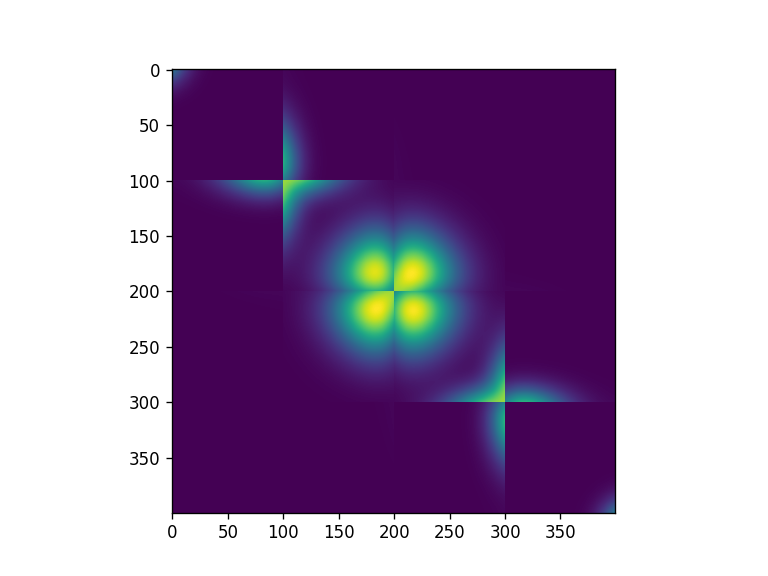

In [49]:
%%px
c_full_range = np.zeros((NX*NY))
comm.Gather(c[1:-1,1:-1].reshape(NX*NY//16), c_full_range, root = 0)
rcoords_x = comm.gather(rcoords[0], root=0)
rcoords_y = comm.gather(rcoords[1], root=0)
if rank == 0:
    xy = np.array([rcoords_x,rcoords_y]).T
    c_plot = np.zeros((NX,NY))
    #print(xy)
#
    for i in np.arange(4):
        for j in np.arange(4):
            k = i*4+j
            xlo = NX//4*xy[k,1]
            xhi = NX//4*(xy[k,1]+1)
            ylo = NY//4*xy[k,0]
            yhi = NY//4*(xy[k,0]+1)
            clo = k*NX*NY//16
            chi = (k+1)*NX*NY//16
            #
            c_plot[xlo:xhi,ylo:yhi] = c_full_range[clo:chi].reshape(NX//4,NY//4)
#
    plt.imshow(c_plot)
    #print(rcoords_all)
    

In [ ]:
import numpy as np
a = np.arange(36).reshape((6,6))

In [ ]:
a

In [ ]:
a[:,-2]

In [27]:
%%px
if rank == 0: print(c_plot.shape)

[stdout:0] (400, 400)


In [ ]:
%%px 
if rank == 0: print(xy)

In [ ]:
%%px
print('Rank {} and to its right {}'.format(rank,cartcomm.Shift(0,1)))

In [ ]:
%%px
print(nysub)

In [48]:
%%px
rcoords

Out[7:46]: [1, 3]

Out[3:46]: [0, 3]

Out[12:46]: [3, 0]

Out[14:46]: [3, 2]

Out[1:46]: [0, 1]

Out[9:46]: [2, 1]

Out[2:46]: [0, 2]

Out[10:46]: [2, 2]

Out[13:46]: [3, 1]

Out[6:46]: [1, 2]

Out[5:46]: [1, 1]

Out[4:46]: [1, 0]

Out[8:46]: [2, 0]

Out[15:46]: [3, 3]

Out[11:46]: [2, 3]

Out[0:46]: [0, 0]

In [47]:
%%px
cartcomm.Shift(1,1)

Out[7:45]: (6, 4)

Out[0:45]: (3, 1)

Out[5:45]: (4, 6)

Out[2:45]: (1, 3)

Out[14:45]: (13, 15)

Out[6:45]: (5, 7)

Out[10:45]: (9, 11)

Out[11:45]: (10, 8)

Out[12:45]: (15, 13)

Out[3:45]: (2, 0)

Out[1:45]: (0, 2)

Out[15:45]: (14, 12)

Out[13:45]: (12, 14)

Out[4:45]: (7, 5)

Out[9:45]: (8, 10)

Out[8:45]: (11, 9)